In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import string
from seaborn import violinplot

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\t\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# read csv
df_CA = pd.read_csv("CAvideos.csv")
df_US = pd.read_csv("USvideos.csv")
df_GB = pd.read_csv("GBvideos.csv")

In [4]:
df_CA

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,n1WpP7iowLc,17.14.11,Eminem - Walk On Water (Audio) ft. Beyoncé,EminemVEVO,10,2017-11-10T17:00:03.000Z,"Eminem|""Walk""|""On""|""Water""|""Aftermath/Shady/In...",17158579,787425,43420,125882,https://i.ytimg.com/vi/n1WpP7iowLc/default.jpg,False,False,False,Eminem's new track Walk on Water ft. Beyoncé i...
1,0dBIkQ4Mz1M,17.14.11,PLUSH - Bad Unboxing Fan Mail,iDubbbzTV,23,2017-11-13T17:00:00.000Z,"plush|""bad unboxing""|""unboxing""|""fan mail""|""id...",1014651,127794,1688,13030,https://i.ytimg.com/vi/0dBIkQ4Mz1M/default.jpg,False,False,False,STill got a lot of packages. Probably will las...
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146035,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095828,132239,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
4,2Vv-BfVoq4g,17.14.11,Ed Sheeran - Perfect (Official Music Video),Ed Sheeran,10,2017-11-09T11:04:14.000Z,"edsheeran|""ed sheeran""|""acoustic""|""live""|""cove...",33523622,1634130,21082,85067,https://i.ytimg.com/vi/2Vv-BfVoq4g/default.jpg,False,False,False,🎧: https://ad.gt/yt-perfect\n💰: https://atlant...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40876,sGolxsMSGfQ,18.14.06,HOW2: How to Solve a Mystery,Annoying Orange,24,2018-06-13T18:00:07.000Z,"annoying orange|""funny""|""fruit""|""talking""|""ani...",80685,1701,99,1312,https://i.ytimg.com/vi/sGolxsMSGfQ/default.jpg,False,False,False,🚨 NEW MERCH! http://amzn.to/annoyingorange 🚨➤ ...
40877,8HNuRNi8t70,18.14.06,Eli Lik Lik Episode 13 Partie 01,Elhiwar Ettounsi,24,2018-06-13T19:01:18.000Z,"hkayet tounsia|""elhiwar ettounsi""|""denya okhra...",103339,460,66,51,https://i.ytimg.com/vi/8HNuRNi8t70/default.jpg,False,False,False,► Retrouvez vos programmes préférés : https://...
40878,GWlKEM3m2EE,18.14.06,KINGDOM HEARTS III – SQUARE ENIX E3 SHOWCASE 2...,Kingdom Hearts,20,2018-06-11T17:30:53.000Z,"Kingdom Hearts|""KH3""|""Kingdom Hearts 3""|""Froze...",773347,25900,224,3881,https://i.ytimg.com/vi/GWlKEM3m2EE/default.jpg,False,False,False,Find out more about Kingdom Hearts 3: https://...
40879,lbMKLzQ4cNQ,18.14.06,Trump Advisor Grovels To Trudeau,The Young Turks,25,2018-06-13T04:00:05.000Z,"180612__TB02SorryExcuse|""News""|""Politics""|""The...",115225,2115,182,1672,https://i.ytimg.com/vi/lbMKLzQ4cNQ/default.jpg,False,False,False,Peter Navarro isn’t talking so tough now. Ana ...


In [5]:
print(list(df_CA.columns.values))

['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']


In [6]:
print(len(df_CA), len(df_US), len(df_GB))

40881 40949 38916


In [7]:
df = pd.concat([df_CA , df_US, df_GB])
len(df)

120746

In [8]:
# only keep ['video_id', 'title', 'channel_title', 'category_id', 'description']
df = df[['video_id', 'title', 'category_id', 'tags','views', 'likes', 'dislikes','description']]

In [9]:
# display nans
for feat in ['video_id', 'title', 'category_id', 'tags','views', 'likes', 'dislikes','description']:
    print("{} --> {}".format(feat, df[feat].isna().sum()))

video_id --> 0
title --> 0
category_id --> 0
tags --> 0
views --> 0
likes --> 0
dislikes --> 0
description --> 2478


In [10]:
# remove nans
df = df.dropna()
len(df)

118268

Identify a dataset to study, and perform an exploratory analysis of the data. Describe the dataset,
including its basic statistics and properties, and report any interesting findings. This exploratory analysis
should motivate the design of your model in the following sections

## Category ID

Text(0.5, 1.0, 'Distribution of Category IDs')

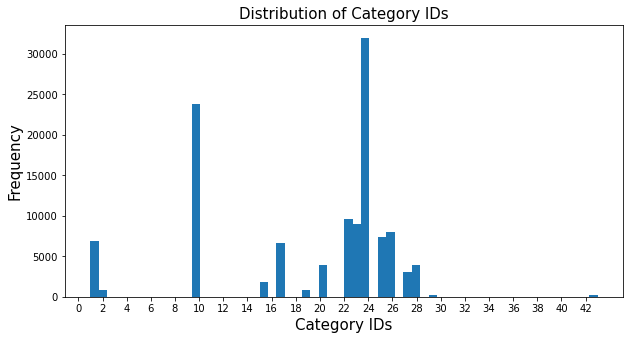

In [11]:
df['category_id'].plot.hist(bins = 60, figsize=(10,5))


plt.xticks(range(0, max(df['category_id']), 2))


plt.xlabel('Category IDs', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of Category IDs', fontsize=15)

In [12]:
cat_list = df['category_id'].to_list()
len(cat_list)

118268

In [13]:
cat_counter = Counter(cat_list)
len(cat_counter.keys())

17

In [14]:
cat_counter.most_common(len(cat_counter.keys()))

[(24, 31972),
 (10, 23790),
 (22, 9605),
 (23, 8962),
 (26, 8059),
 (25, 7441),
 (1, 6896),
 (17, 6661),
 (28, 3980),
 (20, 3894),
 (27, 3081),
 (15, 1813),
 (19, 875),
 (2, 871),
 (43, 201),
 (29, 161),
 (30, 6)]

In [15]:
# unique vals
cat_counter.keys()

dict_keys([10, 23, 24, 25, 22, 26, 1, 28, 20, 17, 29, 15, 19, 2, 27, 43, 30])

In [16]:
print((cat_counter.most_common(1))[0][1]/len(cat_list))
print((cat_counter.most_common(2))[1][1]/len(cat_list))

0.2703351709676328
0.20115331281496263


<ipython-input-17-a50711b846e5>:8: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  plt.pie(cat_chart, labels=my_labels)


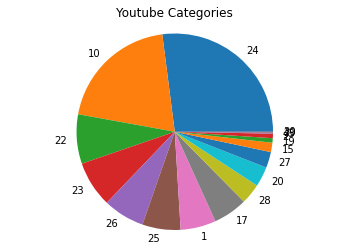

In [17]:
cats = df['category_id'].value_counts()
cat_chart = [cats]


my_labels = [pair[0] for pair in cat_counter.most_common(len(cats))]


plt.pie(cat_chart, labels=my_labels)

plt.title('Youtube Categories')
plt.axis('equal')

plt.show()

In [18]:
# getting rid of all ids after 17, the top 10
top_cats = cat_counter.keys()
top_cats = list(top_cats)[0:10]
top_cats = set(top_cats)
top_cats

{1, 10, 17, 20, 22, 23, 24, 25, 26, 28}

In [19]:
# df containing only the top 10
# new_df = pd.DataFrame()

# for cat in top_cats:
#     new_df = pd.concat([new_df , df[df['category_id'] == cat] ]) 

# # the data to work with
# df = new_df

# len(new_df)

In [20]:
# cat_list = new_df['category_id'].to_list()
# cat_counter = Counter(cat_list)
# cat_counter.most_common(len(cat_counter.keys()))

## Title Length

In [21]:
# 1 - eda through the title:
# -a length
# -b most common words
# -c language (find a ratio so to deem words non-english), filter based on this ratio

# 1a - eda the lengths of the title
df['title_length'] = df['title'].apply(len)

In [22]:
len_list = df['title_length'].to_list()
len_counter = Counter(len_list)
print("Num unique vals: {}".format(len(len_counter.keys())))

min_val = df['title_length'].min()
max_val = df['title_length'].max()
mean = df['title_length'].mean()
median = df['title_length'].median()
sd = df['likes'].std()
print("Min: {}\nMax: {}\nMedian: {}\nMean: {}\nStd: {}".format(min_val, max_val, mean, median, sd))

Num unique vals: 99
Min: 2
Max: 100
Median: 50.67723306388879
Mean: 48.0
Std: 256183.56985315713


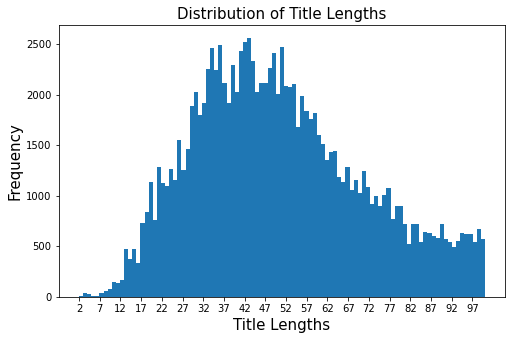

In [23]:
plt.xticks(range(2, max(len_counter.keys()), 5))

plt.xlabel('Title Lengths', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of Title Lengths', fontsize=15)

df['title_length'].plot.hist(bins = len(len_counter.keys()), figsize=(8,5))

In [24]:
df.groupby('category_id')['title_length'].mean()

category_id
1     49.266531
2     51.771527
10    47.885876
15    42.467181
17    64.830506
19    62.390857
20    50.693888
22    46.025508
23    42.715800
24    53.674840
25    60.561887
26    50.045539
27    44.417397
28    39.952513
29    54.813665
30    96.000000
43    41.920398
Name: title_length, dtype: float64

In [25]:
df.groupby('category_id')['title_length'].std()

category_id
1     19.410261
2     18.518631
10    19.060024
15    19.931939
17    21.928356
19    25.529413
20    19.913550
22    20.494406
23    20.282909
24    20.546207
25    20.063775
26    17.503155
27    16.835831
28    16.476720
29    25.293330
30     0.000000
43    14.186037
Name: title_length, dtype: float64

In [26]:
df_std = df.groupby('category_id')['title_length'].std()
# x = df['category_id'].unique()
# y = df_std
# plt.scatter(x, y, c='blue')

# plt.xticks(df['category_id'].unique())

# plt.xlabel('Category ID')
# plt.ylabel('Standard Deviation')
# plt.title('Standard Deviation of Title Length Grouped by Categories')

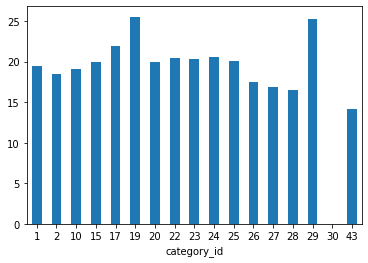

In [27]:
ax = df_std.plot.bar(x='category_id', y='title_length', rot=0)

In [28]:
df.groupby('category_id')['title_length'].max()

category_id
1     100
2     100
10    100
15    100
17    100
19    100
20    100
22    100
23    100
24    100
25    100
26    100
27    100
28    100
29     97
30     96
43     98
Name: title_length, dtype: int64

Text(0.5, 0, 'Category ID')

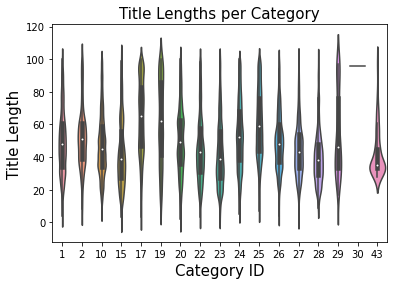

In [29]:
# violin plots for title lengths by category
ax = violinplot(x="category_id", y="title_length", data=df, dodge=False)

ax.set_title("Title Lengths per Category", fontsize=15)
ax.set_ylabel("Title Length", fontsize=15)
ax.set_xlabel("Category ID", fontsize=15)

## Most Common Words for Title

In [30]:
stop_words = set(stopwords.words('english'))  

In [31]:
# eda the most common words
wordCount = defaultdict(int)
punctuation = set(string.punctuation)


for title in df['title']:
    r = ''.join([c for c in title.lower() if not c in punctuation])
    for w in r.split():
        
        if w not in stop_words:
            wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

# Report most common words and their counts
print("Most common words and their counts:")
print(counts[:30])  
print([x[1] for x in counts[:10]])  

Most common words and their counts:
[(12953, 'official'), (10522, 'video'), (8569, '2018'), (5456, 'trailer'), (4836, 'ft'), (3706, 'vs'), (3540, 'music'), (3310, 'new'), (3286, '2'), (3192, 'full'), (3103, '2017'), (3059, 'episode'), (2706, 'hd'), (2511, 'audio'), (2402, 'live'), (2204, 'game'), (2025, '1'), (1991, 'feat'), (1873, 'star'), (1836, 'trump'), (1742, '10'), (1700, 'season'), (1676, 'first'), (1628, 'last'), (1606, 'day'), (1572, 'makeup'), (1545, 'wars'), (1519, '5'), (1517, 'love'), (1506, 'best')]
['official', 'video', '2018', 'trailer', 'ft', 'vs', 'music', 'new', '2', 'full']


In [32]:
# a dictionary of dicts, each inner dict count the words of a certain category
cat_dict = dict()

for cat_id in cat_list:
    cat_dict[cat_id] = defaultdict(int)

# eda the most common words over different categories
for index, row in df.iterrows():
    cat_id = row['category_id']
    title = row['title']
    
    # get dictionary corresponding to this category
    cat_word_count = cat_dict[cat_id]
    
    r = ''.join([c for c in title.lower() if not c in punctuation])
    for w in r.split():
        
        if w not in stop_words and w != '►' and w != '●':
            cat_word_count[w] += 1

In [33]:
for cat_id in cat_dict:
    
    cat_word_count = cat_dict[cat_id]
    
    counts = [(cat_word_count[w], w) for w in cat_word_count]
    counts.sort()
    counts.reverse()

    # Report most common words and their counts
    print("Most common words for Category: {}".format(cat_id))
    print([x[1] for x in counts[:10]])  
    print()

Most common words for Category: 10
['video', 'official', 'ft', 'music', 'audio', 'feat', 'mv', 'live', '2018', 'lyric']

Most common words for Category: 23
['trump', 'look', 'closer', 'show', 'video', 'hart', 'kevin', 'laugh', 'conan', 'vs']

Most common words for Category: 24
['2018', 'trailer', 'official', 'episode', 'hd', '2', 'season', 'star', 'full', '2017']

Most common words for Category: 25
['trump', 'news', '2018', 'president', 'today', 'new', 'live', 'full', 'msnbc', 'house']

Most common words for Category: 22
['2018', 'vs', '2017', 'new', 'video', 'official', 'day', 'full', 'christmas', 'time']

Most common words for Category: 26
['makeup', 'make', 'cake', 'beauty', 'new', 'full', 'face', 'tutorial', 'day', 'vs']

Most common words for Category: 1
['trailer', 'official', '2018', 'hd', 'movie', 'trailers', '2', 'teaser', 'hbo', 'honest']

Most common words for Category: 28
['test', 'gadgets', 'iphone', '—', 'apple', 'x', 'new', 'put', 'review', 'heavy']

Most common words fo

## Most Common Words for Tags

In [34]:
# a dictionary of dicts, each inner dict count the words of a certain category
cat_dict = dict()

for cat_id in cat_list:
    cat_dict[cat_id] = defaultdict(int)

# eda the most common words over different categories
for index, row in df.iterrows():
    cat_id = row['category_id']
    title = row['tags']
    
    # get dictionary corresponding to this category
    cat_word_count = cat_dict[cat_id]
    
    r = ''.join([c for c in title.lower() if not c in punctuation])
    for w in r.split():
        
        if w not in stop_words:
            cat_word_count[w] += 1

In [35]:
for cat_id in cat_dict:
    
    cat_word_count = cat_dict[cat_id]
    
    counts = [(cat_word_count[w], w) for w in cat_word_count]
    counts.sort()
    counts.reverse()

    # Report most common words and their counts
    print("Most common words for Category: {}".format(cat_id))
    print([x[1] for x in counts[:10]])  
    print()

Most common words for Category: 10
['music', 'new', 'official', 'songs', 'feat', 'punjabi', 'ft', 'video', 'puth', 'harris']

Most common words for Category: 23
['tvtelevisionfunnytalk', 'show', 'seth', 'tonight', 'everevery', 'standupfallon', 'videointerviewvarietycomedy', 'monologuetonightshowjokesfunny', 'updatenews', 'showcomedyhumorstandupparodysnl']

Most common words for Category: 24
['voice', 'season', 'late', 'tv', 'last', 'wars', 'episode', 'new', 'mythical', 'norton']

Most common words for Category: 25
['news', 'trump', 'latest', 'tulfo', 'show', 'action', 'newshappening', 'cena', 'donald', 'peterson']

Most common words for Category: 22
['none', 'rogan', 'vs', 'makeup', 'gomez', 'joe', 'cardi', 'fashion', 'versace', 'b']

Most common words for Category: 26
['makeup', 'make', 'face', 'cake', 'de', 'vs', 'beauty', 'star', 'first', 'life']

Most common words for Category: 1
['movie', 'wars', 'trailer', 'clark', 'last', 'none', 'rim', 'theory', 'official', 'star']

Most common

## Most Common Words for Description

In [36]:
# eda the most common words
wordCount = defaultdict(int)
punctuation = set(string.punctuation)


for title in df['description']:
    r = ''.join([c for c in title.lower() if not c in punctuation])
    for w in r.split():
        
        if w not in stop_words:
            wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

# Report most common words and their counts
print("Most common words and their counts:")
print(counts[:30])  

Most common words and their counts:
[(49836, 'video'), (42743, 'music'), (40205, 'us'), (36175, 'new'), (31002, 'videos'), (30283, 'twitter'), (29577, 'channel'), (27946, 'get'), (27141, 'facebook'), (24682, 'instagram'), (24563, 'show'), (24250, 'subscribe'), (23977, 'youtube'), (22537, 'like'), (22169, 'news'), (21114, '►'), (19795, 'official'), (19402, 'one'), (18846, 'watch'), (18054, 'live'), (16390, '2018'), (15878, 'make'), (15332, '–'), (15129, 'n'), (14988, 'use'), (14924, 'love'), (14720, 'late'), (14665, 'know'), (14086, 'full'), (13846, 'first')]


In [37]:
# a dictionary of dicts, each inner dict count the words of a certain category
cat_dict = dict()

for cat_id in cat_list:
    cat_dict[cat_id] = defaultdict(int)

# eda the most common words over different categories
for index, row in df.iterrows():
    cat_id = row['category_id']
    title = row['description']
    
    # get dictionary corresponding to this category
    cat_word_count = cat_dict[cat_id]
    
    r = ''.join([c for c in title.lower() if not c in punctuation])
    for w in r.split():
        
        if w not in stop_words and w != '►' and w != '●':
            cat_word_count[w] += 1

In [38]:
for cat_id in cat_dict:
    
    cat_word_count = cat_dict[cat_id]
    
    counts = [(cat_word_count[w], w) for w in cat_word_count]
    counts.sort()
    counts.reverse()

    # Report most common words and their counts
    print("Most common words for Category: {}".format(cat_id))
    print([x[1] for x in counts[:10]])  
    print()

Most common words for Category: 10
['music', 'video', '–', 'official', 'get', '2018', 'new', 'available', 'album', 'know']

Most common words for Category: 23
['jimmy', 'night', 'show', 'late', 'tonight', '➡', 'seth', 'fallon', 'nbc', 'kimmel']

Most common words for Category: 24
['show', 'videos', 'new', 'video', 'twitter', 'us', 'facebook', 'channel', 'instagram', 'late']

Most common words for Category: 25
['news', 'today', 'twitter', 'facebook', 'subscribe', 'us', 'video', 'msnbc', 'cbs', 'channel']

Most common words for Category: 22
['music', 'via', 'videos', 'video', 'us', 'channel', 'production', 'warner', 'chappell', 'new']

Most common words for Category: 26
['video', 'makeup', 'make', 'channel', 'videos', 'code', 'links', 'n', 'new', 'use']

Most common words for Category: 1
['us', 'movie', 'twitter', 'trailers', 'film', 'facebook', 'new', 'trailer', 'official', 'hbo']

Most common words for Category: 28
['video', 'iphone', 'us', 'twitter', 'new', 'videos', 'music', 'x', 'sm

## Description - Ratio of URL Chars

In [39]:
# ratio of url chars to rest of string in description
cat_url_char_count = defaultdict(int)
cat_nonurl_char_count = defaultdict(int)

    
for index, row in df.iterrows():
    cat_id = row['category_id']
    title = row['description']
    
    r = ''.join([c for c in title.lower() if not c in punctuation])
    for w in r.split():
        
        if w[0:4] == "http":
            cat_url_char_count[cat_id] += len(w)
        else:
            cat_nonurl_char_count[cat_id] += len(w)

In [40]:
for cat_id in cat_url_char_count:
    
    print("Category: {}".format(cat_id))    
    print("Num URL Chars: {} -- Num NonURL Chars: {}".format(cat_url_char_count[cat_id], cat_nonurl_char_count[cat_id]))
    print("Num URL Chars over Total Chars: {}".format(cat_url_char_count[cat_id]/(cat_url_char_count[cat_id] + cat_nonurl_char_count[cat_id])))

Category: 10
Num URL Chars: 4024777 -- Num NonURL Chars: 11901235
Num URL Chars over Total Chars: 0.25271718996569886
Category: 23
Num URL Chars: 2400691 -- Num NonURL Chars: 4608120
Num URL Chars over Total Chars: 0.3425247163891279
Category: 25
Num URL Chars: 1035092 -- Num NonURL Chars: 3875635
Num URL Chars over Total Chars: 0.21078182517578353
Category: 22
Num URL Chars: 1441264 -- Num NonURL Chars: 5232732
Num URL Chars over Total Chars: 0.2159521821709213
Category: 24
Num URL Chars: 6040052 -- Num NonURL Chars: 20291548
Num URL Chars over Total Chars: 0.22938416199547312
Category: 26
Num URL Chars: 2391832 -- Num NonURL Chars: 6786137
Num URL Chars over Total Chars: 0.2606058050533838
Category: 1
Num URL Chars: 1069739 -- Num NonURL Chars: 4018411
Num URL Chars over Total Chars: 0.2102412468185883
Category: 28
Num URL Chars: 1034459 -- Num NonURL Chars: 2572192
Num URL Chars over Total Chars: 0.2868198225999688
Category: 20
Num URL Chars: 667351 -- Num NonURL Chars: 1794216
Num 

## Description - Ratio of NonEnglish Chars

In [41]:
# ratio of uchars to rest of string in description
cat_ascii_count = defaultdict(int)
cat_nonascii_count = defaultdict(int)

    
for index, row in df.iterrows():
    cat_id = row['category_id']
    title = row['description']
    
    r = ''.join([c for c in title.lower() if not c in punctuation])
    for w in r.split():
        
        for c in w:
            if c.isascii():
                cat_ascii_count[cat_id] += 1
                
            else:
                cat_nonascii_count[cat_id] += 1                

In [42]:
for cat_id in cat_url_char_count:
    
    print("Category: {}".format(cat_id))
    print("Num URL Chars: {} -- Num NonURL Chars: {}".format(cat_ascii_count[cat_id], cat_ascii_count[cat_id]))
    print("Num Ascii Chars over Total Chars {}".format(cat_ascii_count[cat_id]/(cat_ascii_count[cat_id] + cat_nonascii_count[cat_id])))

Category: 10
Num URL Chars: 15608259 -- Num NonURL Chars: 15608259
Num Ascii Chars over Total Chars 0.9800481752745132
Category: 23
Num URL Chars: 6895444 -- Num NonURL Chars: 6895444
Num Ascii Chars over Total Chars 0.9838250738962714
Category: 25
Num URL Chars: 4770091 -- Num NonURL Chars: 4770091
Num Ascii Chars over Total Chars 0.9713614705113928
Category: 22
Num URL Chars: 6546387 -- Num NonURL Chars: 6546387
Num Ascii Chars over Total Chars 0.9808796708898238
Category: 24
Num URL Chars: 25496299 -- Num NonURL Chars: 25496299
Num Ascii Chars over Total Chars 0.9682776208054201
Category: 26
Num URL Chars: 9052104 -- Num NonURL Chars: 9052104
Num Ascii Chars over Total Chars 0.986286181615998
Category: 1
Num URL Chars: 4938966 -- Num NonURL Chars: 4938966
Num Ascii Chars over Total Chars 0.9706801096665783
Category: 28
Num URL Chars: 3593901 -- Num NonURL Chars: 3593901
Num Ascii Chars over Total Chars 0.9964648644961767
Category: 20
Num URL Chars: 2434844 -- Num NonURL Chars: 24348

## Likes

Min: 0
Max: 5613827
Median: 83005.93769235973
Mean: 15933.5
Std: 256183.56985315713


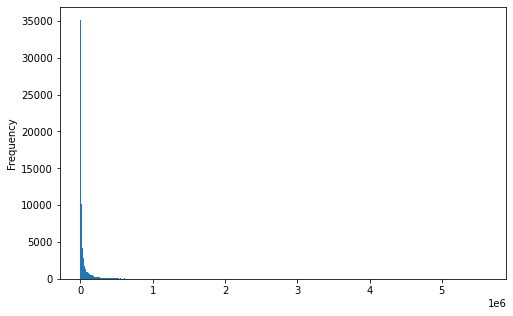

In [43]:
# number of likes
df['likes'].plot.hist(bins = 1000, figsize=(8,5))


min_val = df['likes'].min()
max_val = df['likes'].max()
mean = df['likes'].mean()
median = df['likes'].median()
sd = df['likes'].std()
print("Min: {}\nMax: {}\nMedian: {}\nMean: {}\nStd: {}".format(min_val, max_val, mean, median, sd))

In [44]:
like_bin_counts = [0]*6
# bins for likes, 0 to 1 mill, 1 to 2 mill, etc... up to 5 to 6 mill

# count likes by bins
# for i in range(0,6000000,1000000):
#     like_bin_counts[i] = 0
    
for like_count in df['likes']:
    like_bin_counts[like_count//1000000] += 1

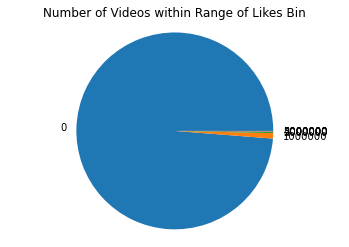

In [45]:
my_labels = range(0,6000000,1000000)


plt.pie(like_bin_counts, labels=my_labels)

plt.title('Number of Videos within Range of Likes Bin')
plt.axis('equal')

plt.show()

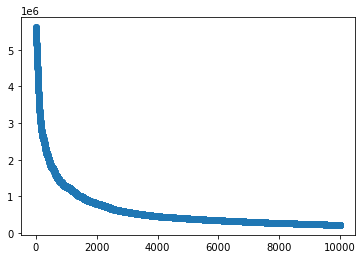

In [46]:
likes_list = [like for like in df['likes']]
likes_list.sort(reverse=True)
small_likes_list = likes_list[0:10000]


plt.scatter(range(len(small_likes_list)), small_likes_list)

In [47]:
# number of likes by category
df.groupby('category_id')['likes'].mean()

category_id
1      56709.017401
2      14358.070034
10    240066.448802
15     23987.011031
17     34834.945053
19     10714.622857
20     48764.978172
22     42759.343571
23     61756.866101
24     50964.426217
25     10796.467813
26     32924.760020
27     28468.749757
28     37718.823116
29    295211.291925
30     42150.833333
43     12480.796020
Name: likes, dtype: float64

In [48]:
df.groupby('category_id')['likes'].std()

category_id
1      99931.429976
2      18270.735486
10    484750.379500
15     30888.728870
17    125232.087839
19      9766.117465
20    104054.792837
22    102882.344387
23    100405.436513
24    165304.437544
25     39540.312321
26     48890.207380
27     51682.790983
28     64320.742214
29    658579.814574
30     22534.365413
43     13453.787999
Name: likes, dtype: float64

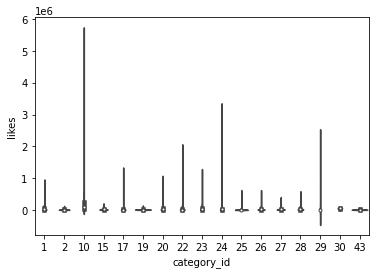

In [49]:
# violin plots for likes by category
ax = violinplot(x="category_id", y="likes", data=df, dodge=False)

## Dislikes

Min: 0
Max: 1753274
Median: 4192.305408056279
Mean: 535.0
Std: 29162.137401482527


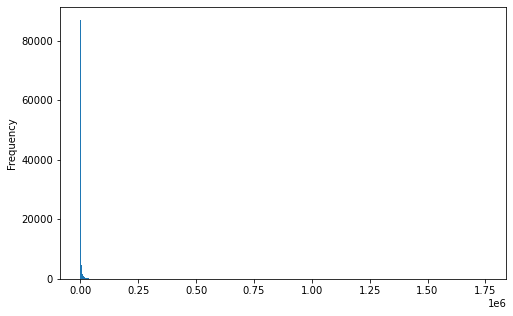

In [50]:
# number of dislikes
df['dislikes'].plot.hist(bins = 1000, figsize=(8,5))


min_val = df['dislikes'].min()
max_val = df['dislikes'].max()
mean = df['dislikes'].mean()
median = df['dislikes'].median()
sd = df['dislikes'].std()
print("Min: {}\nMax: {}\nMedian: {}\nMean: {}\nStd: {}".format(min_val, max_val, mean, median, sd))

In [51]:
dislike_bin_counts = [0]*8
# bins for likes, 0 to 250 thousand, 250 thousand to 500 thousand, etc.. 1750000 to 2 mill

for dislike_count in df['dislikes']:
    dislike_bin_counts[dislike_count//250000] += 1

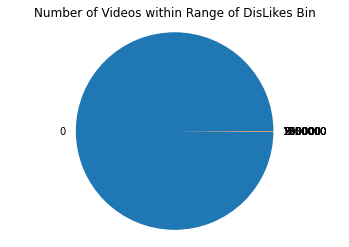

In [52]:
my_labels = range(0,2000000,250000)


plt.pie(dislike_bin_counts, labels=my_labels)

plt.title('Number of Videos within Range of DisLikes Bin')
plt.axis('equal')

plt.show()

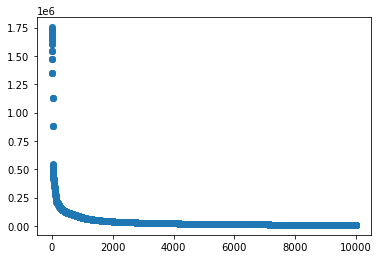

In [53]:
dislikes_list = [like for like in df['dislikes']]
dislikes_list.sort(reverse=True)
small_dislikes_list = dislikes_list[0:10000]


plt.scatter(range(len(small_dislikes_list)), small_dislikes_list)

In [54]:
# number of likes by category
df.groupby('category_id')['dislikes'].mean()

category_id
1      2228.789153
2       828.057405
10     9767.918705
15      594.830667
17     2737.751539
19      557.345143
20     3563.598870
22     3158.805726
23     1915.834635
24     3908.400288
25     1444.299019
26     1092.830500
27      887.388510
28     1938.972864
29    68500.378882
30     2046.666667
43      752.935323
Name: dislikes, dtype: float64

In [55]:
df.groupby('category_id')['dislikes'].std()

category_id
1       4024.952449
2       1923.237030
10     27525.779825
15       798.438173
17     15496.059783
19      1109.045444
20     17379.961477
22     17247.721494
23      3499.154817
24     47023.851558
25      5140.800379
26      2499.624075
27      1430.683633
28      4428.416027
29    156642.688452
30      1375.767664
43       540.208007
Name: dislikes, dtype: float64

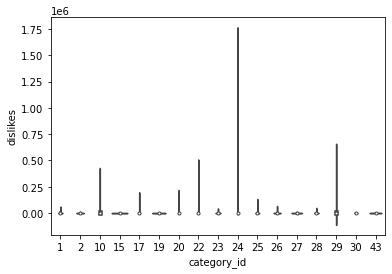

In [56]:
# violin plots for dislikes by category
ax = violinplot(x="category_id", y="dislikes", data=df, dodge=False)

## Likes To Dislikes Ratio

In [57]:
# likes to dislikes ratio

ratios = defaultdict(list) # list of like/total like ratios

for index, row in df.iterrows():
    cat_id = row['category_id']
    likes = row['likes']
    dislikes = row['dislikes']   
    
    ratios[cat_id].append(likes/(likes + dislikes + 1))

In [58]:
for cat_id in ratios:
    
    print("Category: {}".format(cat_id))
    print("Mean Like over Total Likes Ratio: {}".format(np.mean(ratios[cat_id])))
#     print("Max: {}".format(np.max(ratios[cat_id])))
#     print("Min: {}".format(np.min(ratios[cat_id])))
    print("Std: {}".format(np.std(ratios[cat_id])))
    print()

Category: 10
Mean Like over Total Likes Ratio: 0.9598644601194235
Std: 0.06957890442551533

Category: 23
Mean Like over Total Likes Ratio: 0.9578437716598913
Std: 0.05107775367350121

Category: 24
Mean Like over Total Likes Ratio: 0.9222124189727952
Std: 0.11904129567574953

Category: 25
Mean Like over Total Likes Ratio: 0.8289871318319797
Std: 0.18161253941959926

Category: 22
Mean Like over Total Likes Ratio: 0.9134539302638206
Std: 0.15676654776697935

Category: 26
Mean Like over Total Likes Ratio: 0.95925801788716
Std: 0.07284196878757732

Category: 1
Mean Like over Total Likes Ratio: 0.9145044187140503
Std: 0.16010895213696974

Category: 28
Mean Like over Total Likes Ratio: 0.9386328618218814
Std: 0.09646191794904048

Category: 20
Mean Like over Total Likes Ratio: 0.9400304443552293
Std: 0.10186930161222674

Category: 17
Mean Like over Total Likes Ratio: 0.9104054297513754
Std: 0.13583280997847036

Category: 29
Mean Like over Total Likes Ratio: 0.850647776266842
Std: 0.23246427104

## Number of Tags

In [59]:
def count_tags(s):
    
    tags = s.split('|')
    return len(tags)

In [60]:
# number of tags, count pipelines
df['num_tags'] = df['tags'].apply(count_tags)

In [61]:
df['tags']

0        Eminem|"Walk"|"On"|"Water"|"Aftermath/Shady/In...
1        plush|"bad unboxing"|"unboxing"|"fan mail"|"id...
2        racist superman|"rudy"|"mancuso"|"king"|"bach"...
3        ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...
4        edsheeran|"ed sheeran"|"acoustic"|"live"|"cove...
                               ...                        
38911    Enrique Iglesias feat. Pitbull|"MOVE TO MIAMI"...
38912    jacob sartorius|"jacob"|"up with it"|"jacob sa...
38913    anne|"marie"|"anne-marie"|"2002"|"two thousand...
38914    Eurovision Song Contest|"2018"|"Lisbon"|"Cypru...
38915    Kyle|"SuperDuperKyle"|"Ikuyo"|"2 Chainz"|"Soph...
Name: tags, Length: 118268, dtype: object

In [62]:
df['num_tags']

0         6
1        11
2        23
3        14
4        10
         ..
38911     4
38912    41
38913    17
38914     8
38915    18
Name: num_tags, Length: 118268, dtype: int64

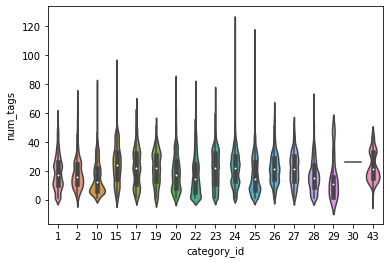

In [63]:
# violin plots for num_tags by category
ax = violinplot(x="category_id", y="num_tags", data=df, dodge=False)

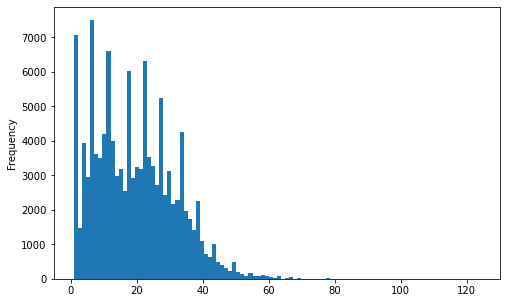

In [64]:
df['num_tags'].plot.hist(bins = 100, figsize=(8,5))

In [65]:
df.groupby('category_id')['num_tags'].mean()

category_id
1     18.693881
2     18.733639
10    15.208365
15    24.430778
17    22.467047
19    21.936000
20    18.741397
22    16.549505
23    21.664472
24    21.852746
25    17.132106
26    22.159325
27    21.512171
28    17.070854
29    15.583851
30    26.000000
43    22.925373
Name: num_tags, dtype: float64

In [66]:
df.groupby('category_id')['num_tags'].std()

category_id
1     11.841501
2     11.384311
10    11.123511
15    13.365811
17    12.758534
19    11.244852
20    12.443725
22    13.499609
23    12.564131
24    11.660993
25    12.185237
26    10.969075
27    10.904393
28    11.631521
29    15.057207
30     0.000000
43     9.869114
Name: num_tags, dtype: float64